# Notebook 4 - Classification of patient composite outcome of COVID19 based on metabolomic features. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. Here, the goal is to identify the best number and combination of features to include in a logistic regression classification model to classify COVID19 patients into two groups with different composite outcomes. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pickle

## Define functions:

In [84]:
def logistic_bootstrap_model(X,y,n_bootstraps = 1000):
    
# Initialize arrays to store bootstrapped FPR and TPR values
    np.random.seed(422)  # Set random seed for reproducibility

    # Initialize arrays to store bootstrapped AUROC values
    bootstrapped_aurocs = np.zeros((n_bootstraps,))
    bootstrapped_fprs = []
    bootstrapped_tprs = []
    #aucs_resampled = []
    for i in range(n_bootstraps):
        # Generate bootstrapped samples with replacement
        indices = np.random.randint(0, len(X), round(len(X)*1))
        indices_left = [x for x in np.arange(0,len(X)) if x not in indices]
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        # Fit logistic regression model on the bootstrapped samples
        logreg_model_bootstrap = LogisticRegression(max_iter = 1000)
        #logreg_model_bootstrap = ElasticNet(max_iter = 1000)
        logreg_model_bootstrap.fit(X_bootstrap, y_bootstrap)

        # Predict probabilities for positive class (class 1) using bootstrapped samples
        y_pred_prob_bootstrap = logreg_model_bootstrap.predict_proba(X[indices_left])[:, 1]

        # Convert probabilities to binary labels using a threshold of 0.5
        y_pred_bootstrap = np.where(y_pred_prob_bootstrap >= 0.5, 1, 0)

        # Calculate false positive rate, true positive rate, and threshold for bootstrapped model
        fpr_bootstrap, tpr_bootstrap, thresholds_bootstrap = roc_curve(y[indices_left], y_pred_prob_bootstrap)
        #auc_bootstrap = auc(fpr)
        # Store FPR and TPR values for bootstrapped model
        bootstrapped_fprs.append(fpr_bootstrap)
        bootstrapped_tprs.append(tpr_bootstrap)

        # Calculate AUROC for bootstrapped model
        bootstrapped_aurocs[i] = auc(fpr_bootstrap, tpr_bootstrap)
    return bootstrapped_aurocs
    
def logistic_regression_roc_with_CI(X,y,title_image = 'AUROC Curve with 95% Confidence Intervals',save_output = False):
    from scipy import interp
    import numpy as np
    from sklearn.linear_model import LogisticRegression, ElasticNet
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    n_bootstraps = 1000  # Specify the number of bootstraps
    np.random.seed(422)  # Set random seed for reproducibility

    # Initialize arrays to store bootstrapped AUROC values
    bootstrapped_aurocs = np.zeros((n_bootstraps,))

    # Initialize arrays to store bootstrapped FPR and TPR values
    bootstrapped_fprs = []
    bootstrapped_tprs = []
    #aucs_resampled = []
    for i in range(n_bootstraps):
        # Generate bootstrapped samples with replacement
        indices = np.random.randint(0, len(X), round(len(X)*1))
        indices_left = [x for x in np.arange(0,len(X)) if x not in indices]
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        # Fit logistic regression model on the bootstrapped samples
        logreg_model_bootstrap = LogisticRegression(max_iter = 1000)
        #logreg_model_bootstrap = ElasticNet(max_iter = 1000)
        logreg_model_bootstrap.fit(X_bootstrap, y_bootstrap)

        # Predict probabilities for positive class (class 1) using bootstrapped samples
        y_pred_prob_bootstrap = logreg_model_bootstrap.predict_proba(X[indices_left])[:, 1]

        # Convert probabilities to binary labels using a threshold of 0.5
        y_pred_bootstrap = np.where(y_pred_prob_bootstrap >= 0.5, 1, 0)

        # Calculate false positive rate, true positive rate, and threshold for bootstrapped model
        fpr_bootstrap, tpr_bootstrap, thresholds_bootstrap = roc_curve(y[indices_left], y_pred_prob_bootstrap)
        #auc_bootstrap = auc(fpr)
        # Store FPR and TPR values for bootstrapped model
        bootstrapped_fprs.append(fpr_bootstrap)
        bootstrapped_tprs.append(tpr_bootstrap)

        # Calculate AUROC for bootstrapped model
        bootstrapped_aurocs[i] = auc(fpr_bootstrap, tpr_bootstrap)

    # Step 4: Calculate confidence intervals

    # Calculate the confidence interval for the bootstrapped AUROC values
    #print(bootstrapped_fprs)
    confidence_interval = np.percentile(bootstrapped_aurocs, q=[2.5, 97.5])
    lower_bound = confidence_interval[0]
    upper_bound = confidence_interval[1]

    # Step 5: Plot the AUROC curve with confidence intervals

    # Plot the average ROC curve for the bootstrapped models
    mean_tpr_ci = []
    mean_fpr = np.linspace(0, 1, 1000)
    mean_tpr = np.zeros_like(mean_fpr)
    for i in range(n_bootstraps):
        tmp_val = np.interp(mean_fpr, bootstrapped_fprs[i], bootstrapped_tprs[i])
        mean_tpr += tmp_val
        mean_tpr_ci.append(tmp_val)
    mean_tpr /= n_bootstraps
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    auc_mean = np.mean(bootstrapped_aurocs)
    
    confidence_interval_tprs = np.percentile(np.array(mean_tpr_ci), q=[2.5, 97.5],axis=0)
    lower_bound_tpr = np.maximum(confidence_interval_tprs[0],0)
    upper_bound_tpr = np.minimum(confidence_interval_tprs[1],1)
    
    # Plot the bootstrapped AUROC curves
    plt.figure(figsize = (8,6))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    #for i in range(n_bootstraps):
    #    plt.plot(bootstrapped_fprs[i], bootstrapped_tprs[i], color='lightgrey', alpha=0.1)
    plt.plot(mean_fpr, mean_tpr, 
             label = r"Mean ROC (AUC = %0.2f)" % (auc_mean),
             color = 'dimgrey')
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color="black", alpha=0.8)
    percentage = 95
    plt.fill_between(
        mean_fpr,
        lower_bound_tpr,
        upper_bound_tpr,
        color="grey",
        alpha=0.2,
        label=r"%.0f%% CI (%0.2f to %0.2f)" % (percentage, lower_bound, upper_bound),
    )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title_image)
    plt.legend(loc="lower right")
    if save_output:
        plt.savefig(title_image+".svg")
    plt.show()
    return


def plot_selected_features(annotated_module,selected_features,expression_data,clinical_data):
    sns.reset_orig()
    colors = ["lightgrey", "dimgrey"]
    sns.set_palette(sns.color_palette(colors))
    sns.set_context("paper")
    #sns.set_style('whitegrid')
    '''
    A function that takes the "annotated_module" and plots the annotated features from the module and plots them according to the 
    "grouping_column" (e.g. clin_orig['Composite'])
    '''
    ann_reduced = annotated_module[annotated_module['feature'].isin(selected_features)].reset_index(drop = True)
    feature_long_df = pd.concat([clinical_data['Composite'],expression_data[expression_data.T.columns.isin(ann_reduced['feature'].tolist())].T],axis = 1)
    dict_names = create_accumulated_dict(ann_reduced['feature'],ann_reduced['metabolite_name'])
    feature_long_df.rename(columns=lambda x: ', '.join(dict_names[x]) if x in dict_names else x, inplace=True)

    # ADD AN IF STATEMENT IF THERE ARE ANY DUPLICATES IN DF:
    
    # create unique identifier for each repeated column
    identifier = feature_long_df.columns.to_series().groupby(level=0).transform('cumcount')
    identifier+=1

    # rename columns with the new identifiers
    new_cols = feature_long_df.columns.astype('string') + '_' + identifier.astype('string')
    new_cols = [item[:-len('_1')] if item.endswith('_1') else item for item in new_cols]
    feature_long_df.columns = new_cols
    #feature_long_df.rename(columns = {'Composite_1':'Composite'},inplace=True)
    
    feature_long_df = feature_long_df.melt(id_vars=['Composite']).reset_index(drop = True)
    #print(feature_long_df)
    
    # Function to split labels at the nearest comma
    def split_labels(label):
        commas = [i for i, char in enumerate(label) if char == ',']
        if commas:
            middle_comma = commas[len(commas) // 2]  # Find the middle comma
            return label[:middle_comma] + '\n' + label[middle_comma+1:]
        else:
            return label

    feature_long_df['variable'] = feature_long_df['variable'].apply(split_labels)

    
    if not plt.get_fignums():
        plt.figure(figsize = (5,10))
    #plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    figg = sns.boxplot(data=feature_long_df, x="value", y="variable",
              hue="Composite", dodge=True, orient = 'h')
    plt.ylabel('', fontsize=16)
    plt.xlabel('Standardized Intensity', fontsize=12)
    #plt.savefig('Between_groups_main_features_JAN2024.svg',format='svg', bbox_inches='tight')
    plt.show()

## Load data:

In [61]:
correlation_df = pd.read_csv('correlation_df_JAN2024.csv',index_col = 0)
correlation_df.columns = correlation_df.columns.astype(int)
eigendf = pd.read_csv('eigendf_trimmed_JAN2024.csv',index_col=0).reset_index(drop = True)
df_modules = pd.read_csv('df_modules_JAN2024.csv',index_col=0).reset_index(drop = True)
expression_data = pd.read_csv('All_data_normalised_21DEC2023.csv',index_col=0).T
all_info = pd.read_csv('xcms_output.csv',index_col=0).reset_index(drop = True)
feature_df = pd.read_csv('feature_df_JAN2024.csv',index_col = 0)
mz_to_mets = pd.read_csv('mz_to_mets_JAN2024.csv',index_col = 0)
clin_orig = pd.read_csv('Clinical_data_covid_study_2023.csv')

with open('module_to_feature_dictionary.pkl', 'rb') as pickle_file:
    mod_dict = pickle.load(pickle_file)

## Get the performance of a logistic regression model (with bootstrap resampling) when a single feature is added in a stepwise fashion. The features used here are the representative features identified from the *"Annotation_procedure"* notebook. They all have putative annotations (not used here). 

In [68]:
X = feature_df
y = clin_orig['Composite']

# Number of features to add in each step
num_features_to_add = 20

# Initialize an empty set to store selected features
selected_features = set()

accuracy_dict = {}
selected_feature_list = []
# Iterate through feature addition steps
for step in range(num_features_to_add):
    best_feature = None
    best_accuracy = 0.0  # Initialize with a value lower than any possible accuracy
    
    # Iterate through remaining features
    for feature in X.columns:
        if feature not in selected_features:
            # Create a subset of features including the current one
            features_subset = list(selected_features) + [feature]
            preds = logistic_bootstrap_model(np.array(X[features_subset]),np.array(y),n_bootstraps=1000)
            accuracy = preds.mean()
            # Check if the current feature improves accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
    accuracy_dict[step] = best_accuracy
    # Add the best feature to the selected features set
    selected_features.add(best_feature)
    selected_feature_list.append(best_feature)
    
    print(f"Step {step + 1} - Added feature: {best_feature}, Accuracy: {best_accuracy}")

Step 1 - Added feature: pos_mz_152.0705369, Accuracy: 0.7076834878773327
Step 2 - Added feature: pos_mz_591.3174449, Accuracy: 0.7331750447157366
Step 3 - Added feature: pos_mz_843.5188545, Accuracy: 0.7652115808570513
Step 4 - Added feature: neg_mz_148.0425231, Accuracy: 0.7895441243367995
Step 5 - Added feature: bas_mz_263.1019867, Accuracy: 0.7982452880216797
Step 6 - Added feature: bas_mz_283.2627966, Accuracy: 0.8017446105331564
Step 7 - Added feature: pos_mz_152.0707117, Accuracy: 0.8061506371116589
Step 8 - Added feature: bas_mz_151.0243094, Accuracy: 0.8074520681227225
Step 9 - Added feature: neg_mz_462.1756792, Accuracy: 0.8109331187171267
Step 10 - Added feature: pos_mz_130.0866381, Accuracy: 0.8101282151631699
Step 11 - Added feature: bas_mz_225.0627733, Accuracy: 0.813598416180277
Step 12 - Added feature: bas_mz_255.231279, Accuracy: 0.8157346760613011
Step 13 - Added feature: pos_mz_120.0656837, Accuracy: 0.8188031376689977
Step 14 - Added feature: pos_mz_118.0863354, Accu

## Visualise how the accuracy of the logistic regression model improves as more features are added:

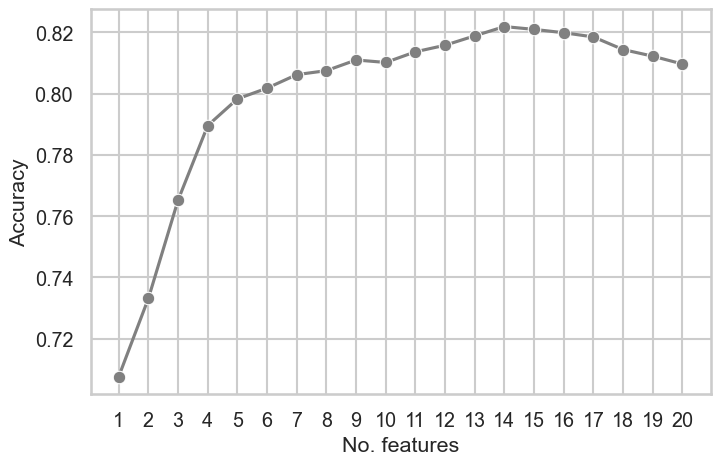

In [89]:
# Convert dictionary items into a list of tuples
items_list = [(key+1, value) for key, value in accuracy_dict.items()]
# Create a DataFrame from the list of tuples
dfd = pd.DataFrame(items_list, columns=['n_feature', 'Accuracy'])

sns.reset_orig()
sns.set_style('whitegrid')
sns.set_context('talk',font_scale=0.86)
plt.figure(figsize = (8,5))
sns.lineplot(data = dfd,x = 'n_feature',y='Accuracy',color = 'grey',marker = 'o')
plt.xticks(range(min(dfd['n_feature']), max(dfd['n_feature'])+1, 1))
plt.xlabel('No. features')
#plt.savefig("elbow_plot_JAN2024.svg")
plt.show()

## How many features to choose?

In [80]:
n_features = 5
chosen_features = selected_feature_list[0:n_features]

## Visualise the ROC curve for the logistic regression model with the chosen amount of features:

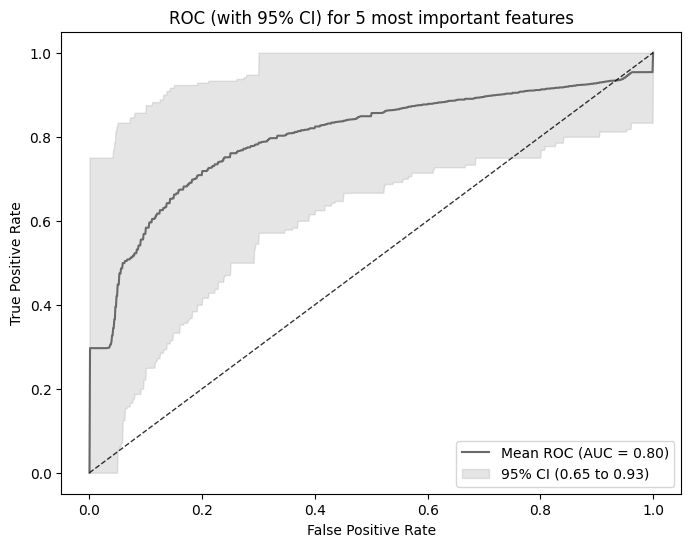

In [82]:
sns.reset_orig()
y_to_use = clin_orig['Composite'].values
X_to_use = np.array(feature_df[chosen_features])
title_of_image = 'ROC (with 95% CI) for '+str(n_features)+' most important features'
logistic_regression_roc_with_CI(X_to_use,y_to_use,title_image=title_of_image,save_output = False)

## How does it compare to SAPS2?

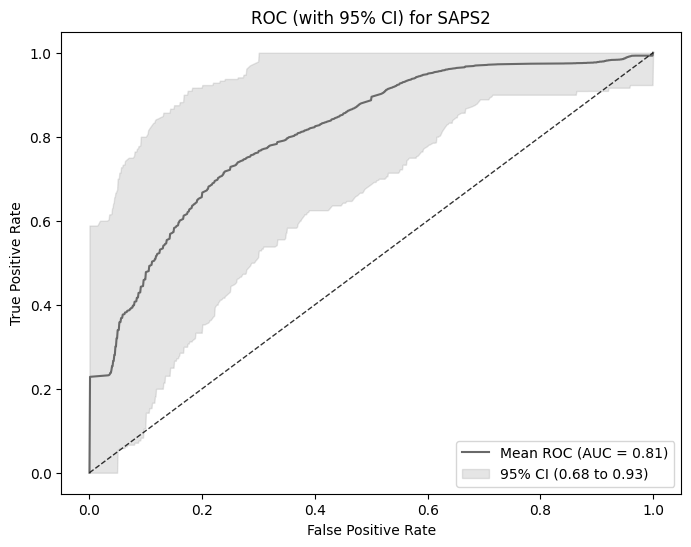

In [79]:
sns.reset_orig()
y_to_use = clin_orig['Composite'].values
X_to_use = np.array(clin_orig['SAPS2'].values).reshape(-1,1)
title_of_image = 'ROC (with 95% CI) for SAPS2'
logistic_regression_roc_with_CI(X_to_use,y_to_use,title_image=title_of_image,save_output = True)

## What about just age?

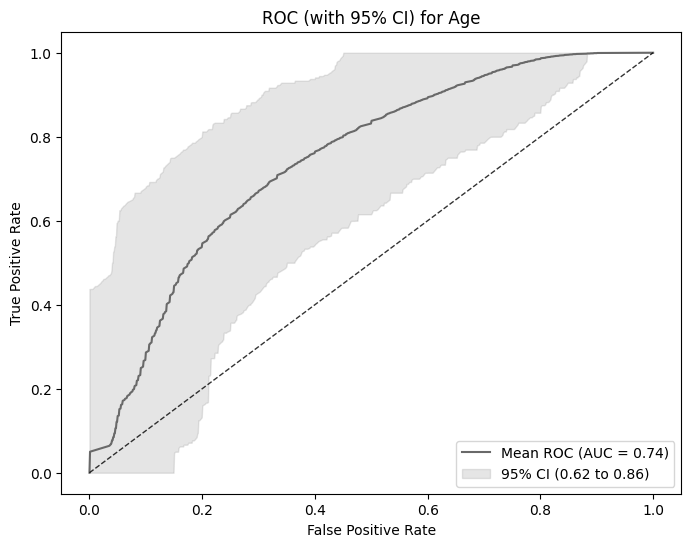

In [78]:
sns.reset_orig()
y_to_use = clin_orig['Composite'].values
X_to_use = np.array(clin_orig['Age'].values).reshape(-1,1)
title_of_image = 'ROC (with 95% CI) for Age'
logistic_regression_roc_with_CI(X_to_use,y_to_use,title_image=title_of_image,save_output = True)

## Save relevant information for the patwhay enrichment analysis:

In [88]:
with open('Chosen_features_from_modeling.pkl', 'wb') as file:
    pickle.dump(chosen_features, file)